# Length Finder
Build a neural network to find the length of a multimode fibre using the input and output fields.

### Prep before code

In [2]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Parameter
import torchoptics
from torchoptics import Field, System, Param
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

from Classes import *

In [3]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [4]:
#fig.savefig(f"Modes Folder/MMF Mode {i+1}.png", dpi = 100)

### Make the Data for the Neural Network to train off of

In [5]:
# Import data
PIM_data = sc.io.loadmat("c:/Users/elija/Documents/MATLAB/MPhys Project/Modes.mat")
modes = PIM_data["F2"].transpose(2,0,1) # Modes
PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

beta_data = sc.io.loadmat("c:/Users/elija/Documents/MATLAB/MPhys Project/Beta.mat")
beta = beta_data["Beta"] # Phase velocities for each mode
beta_torch = torch.tensor(beta, dtype=torch.cfloat)

# Create a fibre from this data
MMF = Fibre(PIMs_torch, beta_torch)

In [6]:
# All 42 PIMs setup as training data for the NN
input_data = PIMs_torch
output_data = MMF.propagate(PIMs_torch[0],1)[None,:,:]

for i in np.arange(1,PIMs_torch.size(dim=0),1):
    output_data = torch.cat((output_data, MMF.propagate(PIMs_torch[i],1)[None,:,:]), dim=0)

print(input_data.shape)
print(output_data.shape)


torch.Size([42, 31, 31])
torch.Size([42, 31, 31])


f:\venv code\Classes.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  


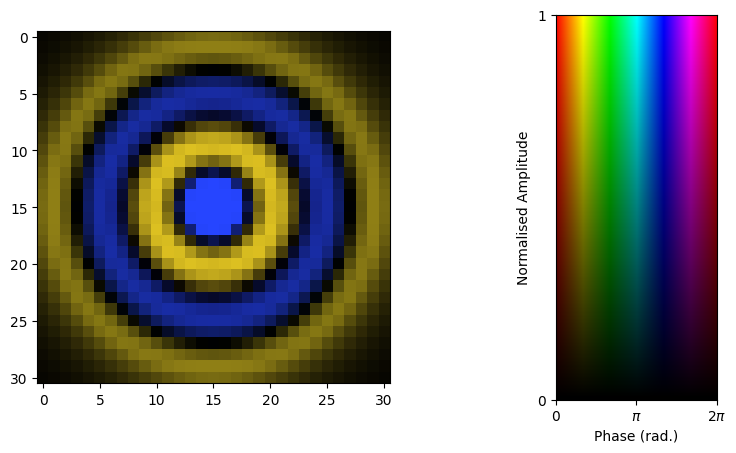

In [7]:
test = Field(output_data[22])
test.visualise()

In [8]:
pim = PIMs_torch[0].reshape((31**2),1)
pim.shape[0]

961

Taking the 42 PIMs individually, feed them (and their propagated counterparts) into the NN to see if it can guess the propagation distance.

# Form the Neural Network

* Make the dataset
* Make the model
* Train the model

In [9]:
class lengthDataset(Dataset):

    def __init__(self, Fields_in_torch: torch.Tensor, Fields_out_torch: torch.Tensor, length_torch: torch.Tensor):

        self.Fields_in_torch = Fields_in_torch.clone().detach()
        self.Fields_out_torch = Fields_out_torch.clone().detach()
        self.length_torch = length_torch.clone().detach()

    def __len__(self):
        """DataLoader needs to know how many examples are in the dataset to train off of."""
        return self.Fields_out_torch.shape[0]
    
    def __getitem__(self, i):
        """Returns the indexed item in the dataset."""
        return torch.squeeze(self.Fields_in_torch[i,:,:]), torch.squeeze(self.length_torch[i,:]), torch.squeeze(self.Fields_out_torch[i,:,:])

#dataset = lengthDataset(torch_in_data, torch_out_data, torch_length)
#dataloader = DataLoader(dataset, batch_size=1)

In [10]:
class lengthModel(nn.Module):
    
    def __init__(self, Fields_in_torch: torch.Tensor, Fields_out_torch: torch.Tensor, length_torch: torch.Tensor, beta, modes):
        super().__init__()

        # Hidden layers
        hidden = nn.Linear((961,42), dtype=torch.cfloat)
        # Parameters
        self.length_torch = length_torch

    def forward(self, Fields_in_torch, length) -> torch.Tensor:
        
        def TM(beta, mode_fields, no_pims, pixel, length):

            beta_arr = np.zeros((no_pims,no_pims)).astype(complex)
            im = np.sqrt(-1+0j)

            # Create the real space to PIM matrix
            pim = mode_fields[0].reshape(pixel,1)

            for i in np.arange(0,no_pims-1,1):
                pim = np.concatenate([pim, mode_fields[i+1].reshape(pixel,1)],axis=1)
    
            # Take the conjugate transpose of the pim matrix to be used in returning the field back to pixel coords
            pim_dag = np.transpose(np.conj(pim))

            # Make a diagonal PIM to PIM TM (each term is exp(i*L*beta), where L is the length of the MMF)
            for i in np.arange(0,no_pims,1):
                for j in np.arange(0,no_pims,1):
                    if i==j:
                        beta_arr[i,j] = np.exp(im*length*beta[i])
                    else:
                        pass
    
            # Combine each matrix to make the full TM for the MMF
            return pim @ beta_arr @ pim_dag

        # Make a vectorising function
        def vectorise(field):
            x = field.shape[0]
            y = field.shape[1]
            return field.reshape(x*y,1)

        # Make an unvectorising function
        def rev_vector(field, dim):
            return field.reshape(dim,dim)

        # Make a propagate function to help save time (and less complexity) in the future
        def propagate(input_field, beta, modes, length):
            # Give option to use TorchOptics fields or not!
            output_field_vector = TM(beta=beta, mode_fields=modes, no_pims=42, pixel=961, L=length) @ vectorise(input_field)
            output_field = rev_vector(output_field_vector,31)

            return output_field

        
        return propagate(Fields_in_torch, beta, modes, self.length)

In [11]:
def loss_function(output_fields, target_fields):
    similarity = 1
    for (n, output_field) in enumerate(output_fields):
        inner_product = (output_field * torch.conj(target_fields[n])).abs()
        similarity = similarity * inner_product.sum()
    return (1-similarity)

In [21]:
length_guess = torch.tensor([0.988], dtype=torch.float32, requires_grad=True)
optimiser = optim.Adam([length_guess], lr=0.00005)

input_fields = []
target_fields = []
for i in range(42):
    field = input_data[i].requires_grad_(True)
    input_fields.append(field)
    target_fields.append(MMF.propagate(field,1).requires_grad_(True))

In [22]:
epochs = 400
for epoch in range(epochs):
    optimiser.zero_grad()
    output_fields = []
    for input_field in input_fields:
        output_fields.append(MMF.propagate(input_field, length_guess).normalise())
    loss = loss_function(output_fields, target_fields)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Length: {length_guess.item()}")

print(f"Optimised length guess: {length_guess.item()}")

Epoch 0, Loss: 0.6575002670288086, Length: 0.9880499839782715
Epoch 100, Loss: 0.65878826379776, Length: 0.9880168437957764
Epoch 200, Loss: 0.6585006713867188, Length: 0.9880286455154419
Epoch 300, Loss: 0.6587702035903931, Length: 0.9879891872406006
Optimised length guess: 0.9880635738372803


### Map out the loss function
To see where the local minima are
* Find the loss value for a range of propagation lengths
* Plot them on a graph